In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

np.set_printoptions(linewidth=500,precision=3,suppress=True)

## Interpoler

On travaille avec des signaux périodiques sur $[0,T]$

In [ ]:
T=5

### Echantilloner...

... c'est enrouler le spectre.

... ou simplement le restreindre s'il est "court".

In [ ]:
def signal_fn(t):
    y= np.sin(2*2*np.pi*t)+0.5*np.sin(4*2*np.pi*t)+0.2*np.sin(10*2*np.pi*t)
    return y

Nous réalisons un premier échantillonnage lisse qui représente précisément le signal.

In [ ]:
sampling_rate_smooth=1000

t=np.linspace(0,T,sampling_rate_smooth*T,endpoint=False)
signal_smooth=signal_fn(t)

fig,ax=plt.subplots(figsize=(10,4))
ax.plot(t,signal_smooth,"-");

Maintenant, on réalise un deuxième échantillonnage, à partir du premier, avec un taux d'échantillonnage vraiment plus faible (c'est un sous-échantillonnage).

Imaginons que le premier enregistrement ait été réalisé avec un enregistreur numérique de très haute qualité, tandis que le deuxième est la compression du premier.

In [ ]:
sampling_rate_raw=25
t=np.linspace(0,T,sampling_rate_raw*T,endpoint=False)
signal_raw=signal_fn(t)

fig,ax=plt.subplots(figsize=(10,4))
ax.plot(t,signal_raw,".-");

### Observer les transformées de Fourier


Voici la fft des deux signaux

In [ ]:
def plot_half_amplitude_spectrum(ax,signal,title,max_freq_plotted):
    N=len(signal)
    n_max_for_plot=int(max_freq_plotted*T)

    half_spectrum=np.fft.rfft(signal)/N
    freqs=np.linspace(0,(N-1)/2/T,len(half_spectrum))


    ax.plot(freqs[:n_max_for_plot],np.abs(half_spectrum)[:n_max_for_plot])
    ax.set_title(title)

In [ ]:
fig,(ax0,ax1)=plt.subplots(2,1,sharex="all")
plot_half_amplitude_spectrum(ax0,signal_smooth,"smooth",50)
plot_half_amplitude_spectrum(ax1,signal_raw,"raw",50)
ax1.set_xlabel("freq in Hz")

Idée: pour interpoler un signal périodique: il suffit de prolonger son spectre par des zéros puis de faire la `ifft`

### Interpoler un signal périodique

périodique = définit sur un cercle

In [ ]:
class CircularHarmonicInterpolator:

    def compute_coef(self,x__x,x__value):
        self.coef = np.fft.rfft(x__value) / len(x__x)

        self.xmax=x__x[-1]
        self.nx=len(x__x)


    def reconstruction(self, n_x_):

        assert n_x_>self.nx

        coef_prolongated=np.zeros([n_x_//2+1],dtype=np.complex128)
        coef_prolongated[:len(self.coef)]=self.coef

        x__value_= np.fft.irfft(coef_prolongated,n=n_x_)*n_x_

        x__x_ = np.linspace(0,self.xmax,n_x_,endpoint=False)

        return x__x_,x__value_

In [ ]:
sampling_rate_raw=25
x__x=np.linspace(0,T,sampling_rate_raw*T,endpoint=False)
x__value=signal_fn(x__x)

In [ ]:
decomposer=CircularHarmonicInterpolator()
decomposer.compute_coef(x__x,x__value)

In [ ]:
x__x_,x__value_=decomposer.reconstruction(10_000)

In [ ]:
fig,axs=plt.subplots(2,1,sharex="all",figsize=(12,4))
axs[0].plot(x__x,x__value)
axs[1].plot(x__x_,x__value_)

## Filtrer

### Signal bruité


In [ ]:
def noisy_signal_fn(t):
    y= np.sin(2*2*np.pi*t)+0.5*np.sin(4*2*np.pi*t)+0.2*np.sin(10*2*np.pi*t)+0.15*np.sin(100*2*np.pi*t)
    return y

T=5#duration

In [ ]:
sampling_rate_smooth=1000

t=np.linspace(0,T,sampling_rate_smooth*T,endpoint=False)
signal_smooth=noisy_signal_fn(t)

fig,ax=plt.subplots(figsize=(10,4))
ax.plot(t,signal_smooth,"-");

In [ ]:
sampling_rate_raw=37
t=np.linspace(0,T,sampling_rate_raw*T,endpoint=False)
signal_raw=noisy_signal_fn(t)

fig,ax=plt.subplots(figsize=(10,4))
ax.plot(t,signal_raw,".-");

### Observer les transformées de Fourier


Voici la fft des deux signaux

In [ ]:
fig,(ax0,ax1)=plt.subplots(2,1,sharex="all")
plot_half_amplitude_spectrum(ax0,signal_smooth,"smooth",50)
plot_half_amplitude_spectrum(ax1,signal_raw,"raw",50)

#### ♡♡♡

Mais quel est ce pic bizarre ?

### Interpolateur+filtreur

Mais on n'est pas obliger d'utiliser toutes les fréquences!

In [ ]:
class CircularHarmonicInterpolatorAndFilter:
    def __init__(self,max_n_coef_kept):
        self.max_n_coef_kept=max_n_coef_kept

    def compute_coef(self,x__x,x__value):
        self.coef = np.fft.rfft(x__value) / len(x__x)
        self.coef=self.coef[:self.max_n_coef_kept]
        self.xmax=x__x[-1]
        self.nx=len(x__x)

    def reconstruction(self, n_x_):

        assert n_x_>2*len(self.coef)
        coef_prolonged=np.zeros([n_x_//2+1],dtype=np.complex128)
        coef_prolonged[:len(self.coef)]=self.coef

        x__value_= np.fft.irfft(coef_prolonged,n=n_x_)*n_x_
        x__x_ = np.linspace(0,self.xmax,n_x_,endpoint=False)

        return x__x_,x__value_

In [ ]:
sampling_rate_raw=37
x__x=np.linspace(0,T,sampling_rate_raw*T,endpoint=False)
x__value=noisy_signal_fn(x__x)

In [ ]:
decomposer=CircularHarmonicInterpolatorAndFilter(40)
decomposer.compute_coef(x__x,x__value)

In [ ]:
x__x_, x__value_=decomposer.reconstruction(10_000)

In [ ]:
fig,axs=plt.subplots(2,1,sharex="all",figsize=(12,4))
axs[0].plot(x__x,x__value)
axs[1].plot(x__x_,x__value_);

## Interférences

### Pour récupérer un signal mal échantillonné

Imaginez : Vous faites une thèse en astronomie. Votre professeur : Huber Rives, vous donne un signal à analyser : c'est un signal de très faible énergie, donc, difficile à détecter. Des instruments embarqués sur un satellite d'observation peuvent vous fournir une discrétisation de ce signal, avec un taux d'échantillonnage de 100Hz (seulement). Voici une conversation :

* (vous) Mais maître, ce taux d'échantillonnage est vraiment trop faible, il y a probablement du repliement de spectre.
* (Huber Rives) Vous avez raison, mais vous n'êtes pas obligé d'ignorer que, théoriquement, les fréquences d'un tel signal vont de 60Hz à 90Hz
* (vous) Ah oui maître, je comprends

(vous n'avez peut-être pas bien compris tout de suite, mais vous allez y réfléchir)

### Pour provoquer l'aliasing

Dans de nombreux domaines scientifiques, on joue avec l'aliasing pour observer des signaux (y compris des images) : certaines ondes de haute fréquence, qui seraient invisibles pour nos détecteurs, deviennent détectables à cause du roulis du spectre.

Pour créer de l'aliasing, on peut provoquer des interférences multiplicatives ou additives, on peut aussi utiliser plusieurs détecteurs distants, ce qui permet de faire des interférences entre un signal et une version décroissante de lui-même.



#### ♡♡♡♡

***À vous :***

*  Pourquoi l'"échantillonnage" peut-il être vu comme une interférence ?

*  Quel est le but de la grille ci-dessous. Cette photo, dont l'échelle est $10\mu m \times 10\mu m$.

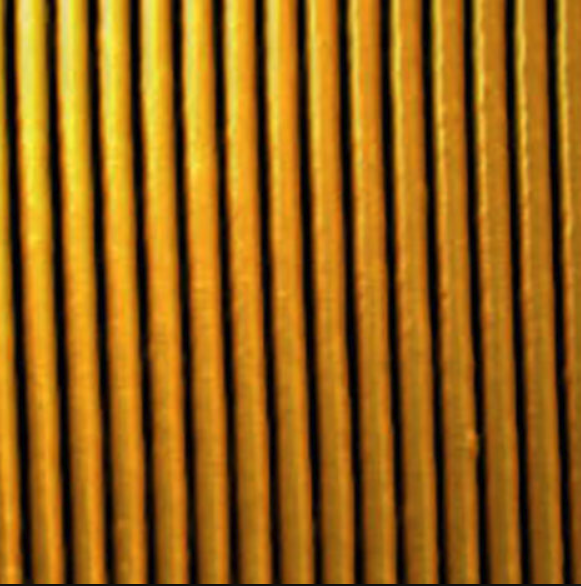